# Set-up

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [2]:
 # Handling summer and winter time
hour_loss_days = [
    20170326,
    20180325,
    20190331,
    20200329,
    20210328,
    20220327
]
hour_gain_days = [
    20171029,
    20181028,
    20191027,
    20201025,
    20211031,
    20221030
]

# Read

## Structural data

In [3]:
struct_df = pd.read_pickle('PC_strut.pickle')
struct_df.head()

,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,CT_PC2
2018-01-01 00:00:00,1.023687,0.433872,-3.072079,-0.745118,0.717989,3.241352
2018-01-01 01:00:00,0.787333,0.214727,-3.269953,-0.389639,0.717989,3.241352
2018-01-01 02:00:00,1.142582,0.517246,-3.511562,-0.682966,0.717989,3.241352
2018-01-01 03:00:00,1.359091,0.692018,-3.635374,-0.274023,0.717989,3.241352
2018-01-01 04:00:00,1.640151,0.729753,-3.703611,-0.167476,1.093151,3.534880


## Exogenous and calendar data

In [4]:

date_df = pd.read_excel('Dati_per_data_1722.xlsx')
date_df.head()

,DATE,HOUR,PzNORD,acquistiMGP,venditeMGP,tecMarg,Pgas,angolosolare,angolodecl,ggsett
0,01/01/2017,1,53.00,11230.358,12531.020,Oliocarbone,19.9,-178.226106,-23.011637,holiday
1,01/01/2017,2,52.00,10658.639,12173.974,Oliocarbone,19.9,-163.226106,-23.011637,holiday
2,01/01/2017,3,51.00,10143.646,10991.049,Ccgt,19.9,-148.226106,-23.011637,holiday
3,01/01/2017,4,47.27,9847.938,9706.109,Ccgt,19.9,-133.226106,-23.011637,holiday
4,01/01/2017,5,45.49,9610.943,8797.656,Ccgt,19.9,-118.226106,-23.011637,holiday


## Unit data

In [5]:

unit_df = pd.read_excel('Dati_per_unita.xlsx')
unit_df.head()

,unit,prov,type
0,UP_ACTV_1,Vercelli,Thermoelectric
1,UP_ALTOADDA_1,Milano,Hydro Run-of-river and poundage
2,UP_ARSIE_1,Belluno,Hydro Run-of-river and poundage
3,UP_AZOTATI_5,Venezia,Fossil Gas
4,UP_BARGI_CEN_1,Bologna,Hydro Pumped Storage


## Market data

In [6]:
market_df = pd.read_parquet('../input_data/5_DatiOfferta/MSD_bids_with_program.parquet')
# Drop 2017 since structural data is missing for that year
market_df = market_df[market_df.BID_OFFER_DATE_DT > 20171231] 
market_df.head()

,BID_OFFER_DATE_DT,INTERVAL_NO,UNIT_REFERENCE_NO,PURPOSE_CD,ACCEPTED,AWARDED_QUANTITY_NO,ADJ_QUANTITY_NO,AS_AWARDED_QUANTITY_NO,OFFERED_PRICE,mgp_mi_binding_program
2091226,20180101,1,UP_ALTOADDA_1,BID,False,0.0,0.0,0.0,18.11,0.0
2091227,20180101,1,UP_ALTOADDA_1,OFF,False,0.0,195.5,0.0,111.74,0.0
2091228,20180101,2,UP_ALTOADDA_1,BID,False,0.0,0.0,0.0,18.11,0.0
2091229,20180101,2,UP_ALTOADDA_1,OFF,False,0.0,195.5,0.0,111.74,0.0
2091230,20180101,3,UP_ALTOADDA_1,BID,False,0.0,0.0,0.0,18.11,0.0


# Merge

## Initialise output dataset

In [7]:
market_df_off = market_df.loc[market_df.PURPOSE_CD == 'OFF', ['BID_OFFER_DATE_DT', 'INTERVAL_NO', 'UNIT_REFERENCE_NO', 'ADJ_QUANTITY_NO']]
market_df_bid = market_df.loc[market_df.PURPOSE_CD == 'BID', ['BID_OFFER_DATE_DT', 'INTERVAL_NO', 'UNIT_REFERENCE_NO', 'ADJ_QUANTITY_NO']]

merge_df = market_df.merge(
    market_df_off,
    how='left',
    on=['BID_OFFER_DATE_DT', 'INTERVAL_NO',	'UNIT_REFERENCE_NO'],
    suffixes=[None, "_OFF"]
)

merge_df = merge_df.merge(
    market_df_bid,
    how='left',
    on=['BID_OFFER_DATE_DT', 'INTERVAL_NO',	'UNIT_REFERENCE_NO'],
    suffixes=[None, "_BID"]
)

merge_df.set_index(market_df.index, inplace=True)
market_df['OFF_QUANTITY'] = merge_df['ADJ_QUANTITY_NO_OFF']
market_df['BID_QUANTITY'] = merge_df['ADJ_QUANTITY_NO_BID']

In [8]:
# Taking only the bids for which a quantity is proposed
print(len(market_df))
market_df = market_df.loc[((market_df['OFF_QUANTITY'] > 0) & (market_df['PURPOSE_CD'] == 'OFF')) | ((market_df['BID_QUANTITY'] > 0) & (market_df['PURPOSE_CD'] == 'BID'))]
print(len(market_df))

10889598
5771266


In [9]:
index = market_df.BID_OFFER_DATE_DT.astype(str) + market_df.INTERVAL_NO.astype(str) + market_df.UNIT_REFERENCE_NO + '_' + market_df.PURPOSE_CD
df = pd.DataFrame(index=index)

market_df.set_index(index, inplace=True)

In [10]:
df['hour'] = market_df.INTERVAL_NO
df['date'] = market_df.BID_OFFER_DATE_DT
df['year'] = df.date.astype(str).str[:4].astype(int)
df['unit'] = market_df.UNIT_REFERENCE_NO
df['scope'] = market_df['PURPOSE_CD']

for day in hour_loss_days:
    # The time change occurs at 2am and the data sets the hour from 1 to 23 for these days
    hours_to_shift = (df.date == day) & (df.hour > 2)
    df.loc[hours_to_shift, 'hour'] = df.loc[hours_to_shift, 'hour'] + 1

for day in hour_gain_days:
    # The time change occurs at 2am and the data sets the hour from 1 to 25 for these days
    hours_to_shift = (df.date == day) & (df.hour > 2)
    df.loc[hours_to_shift, 'hour'] = df.loc[hours_to_shift, 'hour'] - 1


## Add structural data

In [11]:
struct_cols = struct_df.columns
struct_df['date'] = struct_df.index.strftime('%Y%m%d').astype(int)
struct_df['hour'] = struct_df.index.hour + 1

merge_df = df[['date', 'hour']].merge(
    struct_df,
    how='left',
    on=['date', 'hour']
)

merge_df.set_index(index, inplace=True)

In [12]:
df[struct_cols] = merge_df[struct_cols]
df.head(3)

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,CT_PC2
201801011UP_ALTOADDA_1_OFF,1,20180101,2018,UP_ALTOADDA_1,OFF,1.023687,0.433872,-3.072079,-0.745118,0.717989,3.241352
201801012UP_ALTOADDA_1_OFF,2,20180101,2018,UP_ALTOADDA_1,OFF,0.787333,0.214727,-3.269953,-0.389639,0.717989,3.241352
201801013UP_ALTOADDA_1_OFF,3,20180101,2018,UP_ALTOADDA_1,OFF,1.142582,0.517246,-3.511562,-0.682966,0.717989,3.241352


## Add exogenous and calendar data

In [13]:
date_df['DATE'] = pd.to_datetime(date_df.DATE, format='%d/%m/%Y').dt.strftime('%Y%m%d').astype(int)

merge_df = df[['date', 'hour']].merge(
    date_df,
    how='left',
    left_on=['date', 'hour'],
    right_on=['DATE', 'HOUR']
)

merge_df.set_index(index, inplace=True)

In [14]:
df['PurchMGP'] = merge_df['acquistiMGP']
df['SellMGP'] = merge_df['venditeMGP']
df['MargTech'] = merge_df['tecMarg']
df['MGPprice'] = merge_df['PzNORD']
df['GNprice'] = merge_df['Pgas']
df['SolarAngle'] = merge_df['angolosolare']
df['DeclAngle'] = merge_df['angolodecl']
df['WorkDay'] = merge_df['ggsett']
df.head(3)

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,CT_PC2,PurchMGP,SellMGP,MargTech,MGPprice,GNprice,SolarAngle,DeclAngle,WorkDay
201801011UP_ALTOADDA_1_OFF,1,20180101,2018,UP_ALTOADDA_1,OFF,1.023687,0.433872,-3.072079,-0.745118,0.717989,3.241352,11661.749,8176.298,Carbone,45.73,20.107,-178.226106,-23.011637,holiday
201801012UP_ALTOADDA_1_OFF,2,20180101,2018,UP_ALTOADDA_1,OFF,0.787333,0.214727,-3.269953,-0.389639,0.717989,3.241352,11095.782,7683.106,Carbone,44.16,20.107,-163.226106,-23.011637,holiday
201801013UP_ALTOADDA_1_OFF,3,20180101,2018,UP_ALTOADDA_1,OFF,1.142582,0.517246,-3.511562,-0.682966,0.717989,3.241352,10709.883,7315.858,Ccgt,42.24,20.107,-148.226106,-23.011637,holiday


## Add unit data

In [15]:
merge_df = df[['unit']].merge(
    unit_df,
    how='left',
    on=['unit']
)

merge_df.set_index(index, inplace=True)

In [16]:
df['Prov'] = merge_df['prov']
df['Tech'] = merge_df['type']
df.head()

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,PurchMGP,SellMGP,MargTech,MGPprice,GNprice,SolarAngle,DeclAngle,WorkDay,Prov,Tech
201801011UP_ALTOADDA_1_OFF,1,20180101,2018,UP_ALTOADDA_1,OFF,1.023687,0.433872,-3.072079,-0.745118,0.717989,...,11661.749,8176.298,Carbone,45.73,20.107,-178.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage
201801012UP_ALTOADDA_1_OFF,2,20180101,2018,UP_ALTOADDA_1,OFF,0.787333,0.214727,-3.269953,-0.389639,0.717989,...,11095.782,7683.106,Carbone,44.16,20.107,-163.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage
201801013UP_ALTOADDA_1_OFF,3,20180101,2018,UP_ALTOADDA_1,OFF,1.142582,0.517246,-3.511562,-0.682966,0.717989,...,10709.883,7315.858,Ccgt,42.24,20.107,-148.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage
201801014UP_ALTOADDA_1_OFF,4,20180101,2018,UP_ALTOADDA_1,OFF,1.359091,0.692018,-3.635374,-0.274023,0.717989,...,10381.797,6911.034,Carbone,39.29,20.107,-133.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage
201801015UP_ALTOADDA_1_OFF,5,20180101,2018,UP_ALTOADDA_1,OFF,1.640151,0.729753,-3.703611,-0.167476,1.093151,...,10236.265,6645.689,Carbone,36.00,20.107,-118.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage


## Add market data

$$PV=\frac{|Binding Program|}{|Binding Program| + QuantityOfferedMSD}$$

The formula below allows to take care of the cases when the binding program is negative, which can be the case for hydro pumped storages

Alternative possibility:
$$PV=\frac{\text{MSD Bid Qty}}{\text{MSD Bid Qty} + \text{MSD Off Qty}}$$

In [17]:
# Binding program just before GR bids
# Binding program after commercial markets + eventual technical minimum (off) or shutdown (bid) accepted before GR bids
binding_program = market_df.mgp_mi_binding_program + market_df.PURPOSE_CD.map({'BID': -1, 'OFF': 1}) * market_df.AS_AWARDED_QUANTITY_NO
market_df['PV'] = binding_program.abs() / (binding_program.abs() + market_df['OFF_QUANTITY']) # we take absolute value in case of negative binding program (e.g. pumped storage)
market_df['PVnew'] = market_df.BID_QUANTITY / (market_df.BID_QUANTITY + market_df.OFF_QUANTITY)

In [18]:
col = 'PV'
#market_df[market_df[col].isna() | np.isinf(market_df[col])]
market_df[market_df[col].isna()]

,BID_OFFER_DATE_DT,INTERVAL_NO,UNIT_REFERENCE_NO,PURPOSE_CD,ACCEPTED,AWARDED_QUANTITY_NO,ADJ_QUANTITY_NO,AS_AWARDED_QUANTITY_NO,OFFERED_PRICE,mgp_mi_binding_program,OFF_QUANTITY,BID_QUANTITY,PV,PVnew
201801011UP_RIVADEL_3_BID,20180101,1,UP_RIVADEL_3,BID,False,0.0,49.0,0.0,1.00,0.0,0.0,49.0,NaN,1.0
201801012UP_RIVADEL_3_BID,20180101,2,UP_RIVADEL_3,BID,False,0.0,49.0,0.0,1.00,0.0,0.0,49.0,NaN,1.0
201801013UP_RIVADEL_3_BID,20180101,3,UP_RIVADEL_3,BID,False,0.0,49.0,0.0,1.00,0.0,0.0,49.0,NaN,1.0
201801014UP_RIVADEL_3_BID,20180101,4,UP_RIVADEL_3,BID,False,0.0,49.0,0.0,1.00,0.0,0.0,49.0,NaN,1.0
201801015UP_RIVADEL_3_BID,20180101,5,UP_RIVADEL_3,BID,False,0.0,49.0,0.0,1.00,0.0,0.0,49.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022122717UP_ACTV_1_BID,20221227,17,UP_ACTV_1,BID,False,0.0,8.7,0.0,0.01,0.0,0.0,8.7,NaN,1.0
2022123013UP_MONFALCO_1_BID,20221230,13,UP_MONFALCO_1,BID,False,0.0,27.0,0.0,172.86,0.0,0.0,27.0,NaN,1.0
2022123014UP_MONFALCO_1_BID,20221230,14,UP_MONFALCO_1,BID,False,0.0,27.0,0.0,130.00,0.0,0.0,27.0,NaN,1.0
2022123015UP_MONFALCO_1_BID,20221230,15,UP_MONFALCO_1,BID,False,0.0,27.0,0.0,195.33,0.0,0.0,27.0,NaN,1.0


Don't understand why there could be some NA values so we will just drop them

In [19]:
df['PV'] = market_df['PV'].round(3)
df['Price'] = market_df['OFFERED_PRICE']
df['PriceDiff'] = ((df['Price'] - df['MGPprice']) / df['MGPprice'].abs()).round(3)
df['Result'] = market_df['ACCEPTED']

df = df[~df.PV.isna()]
df.head()

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,GNprice,SolarAngle,DeclAngle,WorkDay,Prov,Tech,PV,Price,PriceDiff,Result
201801011UP_ALTOADDA_1_OFF,1,20180101,2018,UP_ALTOADDA_1,OFF,1.023687,0.433872,-3.072079,-0.745118,0.717989,...,20.107,-178.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.0,111.74,1.443,False
201801012UP_ALTOADDA_1_OFF,2,20180101,2018,UP_ALTOADDA_1,OFF,0.787333,0.214727,-3.269953,-0.389639,0.717989,...,20.107,-163.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.0,111.74,1.530,False
201801013UP_ALTOADDA_1_OFF,3,20180101,2018,UP_ALTOADDA_1,OFF,1.142582,0.517246,-3.511562,-0.682966,0.717989,...,20.107,-148.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.0,111.74,1.645,False
201801014UP_ALTOADDA_1_OFF,4,20180101,2018,UP_ALTOADDA_1,OFF,1.359091,0.692018,-3.635374,-0.274023,0.717989,...,20.107,-133.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.0,111.74,1.844,False
201801015UP_ALTOADDA_1_OFF,5,20180101,2018,UP_ALTOADDA_1,OFF,1.640151,0.729753,-3.703611,-0.167476,1.093151,...,20.107,-118.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.0,111.74,2.104,False


In [21]:
df

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,GNprice,SolarAngle,DeclAngle,WorkDay,Prov,Tech,PV,Price,PriceDiff,Result
201801011UP_ALTOADDA_1_OFF,1,20180101,2018,UP_ALTOADDA_1,OFF,1.023687,0.433872,-3.072079,-0.745118,0.717989,...,20.107,-178.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.000,111.74,1.443,False
201801012UP_ALTOADDA_1_OFF,2,20180101,2018,UP_ALTOADDA_1,OFF,0.787333,0.214727,-3.269953,-0.389639,0.717989,...,20.107,-163.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.000,111.74,1.530,False
201801013UP_ALTOADDA_1_OFF,3,20180101,2018,UP_ALTOADDA_1,OFF,1.142582,0.517246,-3.511562,-0.682966,0.717989,...,20.107,-148.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.000,111.74,1.645,False
201801014UP_ALTOADDA_1_OFF,4,20180101,2018,UP_ALTOADDA_1,OFF,1.359091,0.692018,-3.635374,-0.274023,0.717989,...,20.107,-133.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.000,111.74,1.844,False
201801015UP_ALTOADDA_1_OFF,5,20180101,2018,UP_ALTOADDA_1,OFF,1.640151,0.729753,-3.703611,-0.167476,1.093151,...,20.107,-118.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.000,111.74,2.104,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022123121UP_VOGHERA_1_BID,21,20221231,2022,UP_VOGHERA_1,BID,-0.075154,-0.954465,-1.872673,0.745683,-2.449869,...,72.000,121.887169,-23.085911,holiday,Pavia,Fossil Gas,0.573,143.00,-0.539,False
2022123121UP_VOGHERA_1_OFF,21,20221231,2022,UP_VOGHERA_1,OFF,-0.075154,-0.954465,-1.872673,0.745683,-2.449869,...,72.000,121.887169,-23.085911,holiday,Pavia,Fossil Gas,0.573,320.00,0.032,False
2022123122UP_VOGHERA_1_OFF,22,20221231,2022,UP_VOGHERA_1,OFF,2.244316,-3.847872,-2.345759,0.833482,-2.547642,...,72.000,136.887169,-23.085911,holiday,Pavia,Fossil Gas,0.526,320.00,0.185,False
2022123123UP_VOGHERA_1_OFF,23,20221231,2022,UP_VOGHERA_1,OFF,2.277886,-3.849805,-2.698679,0.834434,-2.527069,...,72.000,151.887169,-23.085911,holiday,Pavia,Fossil Gas,0.525,320.00,0.469,False


In [20]:
df[df.scope == 'BID'].to_pickle('ML_dataset_BID.pkl')
df[df.scope == 'OFF'].to_pickle('ML_dataset_OFF.pkl')

# Tests

In [41]:
df

,hour,date,year,unit,scope
201801011UP_ALTOADDA_1_BID,1,20180101,2018,UP_ALTOADDA_1,BID
201801011UP_ALTOADDA_1_OFF,1,20180101,2018,UP_ALTOADDA_1,OFF
201801012UP_ALTOADDA_1_BID,2,20180101,2018,UP_ALTOADDA_1,BID
201801012UP_ALTOADDA_1_OFF,2,20180101,2018,UP_ALTOADDA_1,OFF
201801013UP_ALTOADDA_1_BID,3,20180101,2018,UP_ALTOADDA_1,BID
...,...,...,...,...,...
2022123122UP_VOGHERA_1_OFF,22,20221231,2022,UP_VOGHERA_1,OFF
2022123123UP_VOGHERA_1_BID,23,20221231,2022,UP_VOGHERA_1,BID
2022123123UP_VOGHERA_1_OFF,23,20221231,2022,UP_VOGHERA_1,OFF
2022123124UP_VOGHERA_1_BID,24,20221231,2022,UP_VOGHERA_1,BID


In [44]:
print(len(df[(df.year==2019) & (df.scope=='BID')]))
print(len(df[(df.year==2019) & (df.scope=='OFF')]))

1108949
1108949


In [45]:
df.unit.nunique()

131

<Axes: xlabel='year', ylabel='Price'>

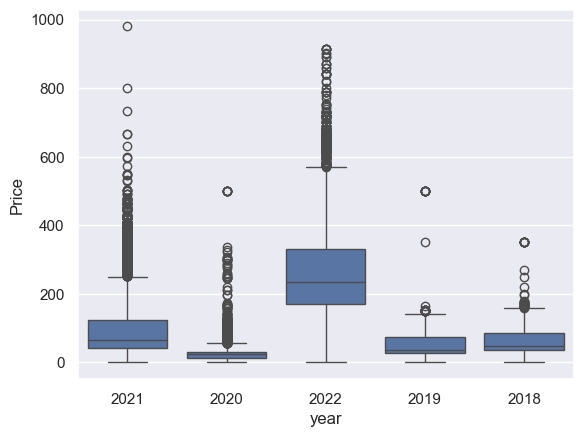

In [21]:
test_df = df.copy()
test_df['year'] = df.date.astype(str).str[:4]

#plt.figure(figsize=(12, 8))
sns.boxplot(
    x = 'year',
    y = 'Price',
    data = test_df[test_df.Result].sample(frac=0.1),
    #showfliers = False,
    #whis = (2, 98),
    #palette = 'cool',
)

In [21]:
df

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,GNprice,SolarAngle,DeclAngle,WorkDay,Prov,Tech,PV,Price,PriceDiff,Result
201801011UP_ALTOADDA_1_BID,1,20180101,2018,UP_ALTOADDA_1,BID,1.023687,0.433872,-3.072079,-0.745118,0.717989,...,20.107,-178.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.000,18.11,-0.604,False
201801011UP_ALTOADDA_1_OFF,1,20180101,2018,UP_ALTOADDA_1,OFF,1.023687,0.433872,-3.072079,-0.745118,0.717989,...,20.107,-178.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.000,111.74,1.443,False
201801012UP_ALTOADDA_1_BID,2,20180101,2018,UP_ALTOADDA_1,BID,0.787333,0.214727,-3.269953,-0.389639,0.717989,...,20.107,-163.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.000,18.11,-0.590,False
201801012UP_ALTOADDA_1_OFF,2,20180101,2018,UP_ALTOADDA_1,OFF,0.787333,0.214727,-3.269953,-0.389639,0.717989,...,20.107,-163.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.000,111.74,1.530,False
201801013UP_ALTOADDA_1_BID,3,20180101,2018,UP_ALTOADDA_1,BID,1.142582,0.517246,-3.511562,-0.682966,0.717989,...,20.107,-148.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.000,18.11,-0.571,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022123122UP_VOGHERA_1_OFF,22,20221231,2022,UP_VOGHERA_1,OFF,2.244316,-3.847872,-2.345759,0.833482,-2.547642,...,72.000,136.887169,-23.085911,holiday,Pavia,Fossil Gas,0.526,320.00,0.185,False
2022123123UP_VOGHERA_1_BID,23,20221231,2022,UP_VOGHERA_1,BID,2.277886,-3.849805,-2.698679,0.834434,-2.527069,...,72.000,151.887169,-23.085911,holiday,Pavia,Fossil Gas,0.525,141.00,-0.353,False
2022123123UP_VOGHERA_1_OFF,23,20221231,2022,UP_VOGHERA_1,OFF,2.277886,-3.849805,-2.698679,0.834434,-2.527069,...,72.000,151.887169,-23.085911,holiday,Pavia,Fossil Gas,0.525,320.00,0.469,False
2022123124UP_VOGHERA_1_BID,24,20221231,2022,UP_VOGHERA_1,BID,2.820551,-4.227505,-2.946628,0.795178,-3.041510,...,72.000,166.887169,-23.085911,holiday,Pavia,Fossil Gas,0.525,139.00,-0.305,False


In [23]:
df[(df.date == 20190614) & (df.scope == 'BID')].to_excel('test_bid.xlsx')
df[(df.date == 20190614) & (df.scope == 'OFF')].to_excel('test_off.xlsx')

In [24]:
old_df = pd.read_pickle('/Users/guillaume/Documents/GitHub/prometheus/dw/data/DBdw_2019.pickle')
old_df

,hour,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,CT_PC2,PurchMGP,SellMGP,MargTech,GNprice,SolarAngle,DeclAngle,WorkDay,Prov,Tech,PV,Price,Target,Result
idx,,,,,,,,,,,,,,,,,,,,
01/01/20191UP_BARGI_CEN_1,1,3.353367,0.050663,-3.76401,0.464396,-1.042284,2.704958,11460.324,9179.693,Ccgt,23.11,-178.226106,-23.011637,holiday,Bologna,Hydro Pumped Storage,0.0,0.0,0.0,0.0
01/01/20191UP_BORGO_TRE_1,1,3.353367,0.050663,-3.76401,0.464396,-1.042284,2.704958,11460.324,9179.693,Ccgt,23.11,-178.226106,-23.011637,holiday,Verona,Fossil Gas,0.913793,0.02,0.0,0.0
01/01/20191UP_BRUNICO_M_1,1,3.353367,0.050663,-3.76401,0.464396,-1.042284,2.704958,11460.324,9179.693,Ccgt,23.11,-178.226106,-23.011637,holiday,Bolzano,Hydro Water Reservoir,0.0,0.0,0.0,0.0
01/01/20191UP_CLHRCSLGNO_1,1,3.353367,0.050663,-3.76401,0.464396,-1.042284,2.704958,11460.324,9179.693,Ccgt,23.11,-178.226106,-23.011637,holiday,Bologna,Thermoelectric,0.833093,30.0,0.0,0.0
01/01/20191UP_CNTRLDTRNL_1,1,3.353367,0.050663,-3.76401,0.464396,-1.042284,2.704958,11460.324,9179.693,Ccgt,23.11,-178.226106,-23.011637,holiday,Lodi,Fossil Gas,0.0,30.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31/12/201924UP_TELESSIO_1,24,0.099112,0.710441,-3.129271,0.576563,-1.134962,2.580572,12643.607,11719.197,Ccgt,13.773,166.887169,-23.085911,weekday,Torino,Hydro Pumped Storage,0.0,0.0,0.0,0.0
31/12/201924UP_TORINONORD_1,24,0.099112,0.710441,-3.129271,0.576563,-1.134962,2.580572,12643.607,11719.197,Ccgt,13.773,166.887169,-23.085911,weekday,Torino,Fossil Gas,1.0,0.0,0.317073,1
31/12/201924UP_TORVISCOSA_1,24,0.099112,0.710441,-3.129271,0.576563,-1.134962,2.580572,12643.607,11719.197,Ccgt,13.773,166.887169,-23.085911,weekday,Udine,Fossil Gas,1.0,19.920634,0.881223,1


In [25]:

old_df = old_df[old_df.index.str.startswith('14/06/2019')]
old_df.to_excel('test_bid_old.xlsx')
old_df

,hour,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,CT_PC2,PurchMGP,SellMGP,MargTech,GNprice,SolarAngle,DeclAngle,WorkDay,Prov,Tech,PV,Price,Target,Result
idx,,,,,,,,,,,,,,,,,,,,
14/06/20191UP_ALTOADDA_1,1,1.124324,0.091741,-1.502287,-0.011703,0.525921,-0.287162,16706.305,13765.501,Ccgt,14.708,-192.46815,23.267611,weekday,Milano,Hydro Run-of-river and poundage,0.520231,5.15,0.0,0.0
14/06/20191UP_BARGI_CEN_1,1,1.124324,0.091741,-1.502287,-0.011703,0.525921,-0.287162,16706.305,13765.501,Ccgt,14.708,-192.46815,23.267611,weekday,Bologna,Hydro Pumped Storage,0.0,30.1,0.0,0.0
14/06/20191UP_BATTIGGIO_1,1,1.124324,0.091741,-1.502287,-0.011703,0.525921,-0.287162,16706.305,13765.501,Ccgt,14.708,-192.46815,23.267611,weekday,Verbano-Cusio-Ossola,Hydro Run-of-river and poundage,0.989899,0.01,0.0,0.0
14/06/20191UP_BORGO_TRE_1,1,1.124324,0.091741,-1.502287,-0.011703,0.525921,-0.287162,16706.305,13765.501,Ccgt,14.708,-192.46815,23.267611,weekday,Verona,Fossil Gas,0.0,0.02,0.0,0.0
14/06/20191UP_BRUNICO_M_1,1,1.124324,0.091741,-1.502287,-0.011703,0.525921,-0.287162,16706.305,13765.501,Ccgt,14.708,-192.46815,23.267611,weekday,Bolzano,Hydro Water Reservoir,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14/06/201924UP_VADOTERM_5,24,-0.227462,1.436238,-0.502162,0.305145,1.019562,-0.082089,17075.282,14557.282,Ccgt,14.708,152.53185,23.267611,weekday,Savona,Fossil Gas,1.0,12.02318,0.75871,1
14/06/201924UP_VALCAMONICA_1,24,-0.227462,1.436238,-0.502162,0.305145,1.019562,-0.082089,17075.282,14557.282,Ccgt,14.708,152.53185,23.267611,weekday,Varese,Hydro Run-of-river and poundage,0.952381,0.01,0.0,0.0
14/06/201924UP_VALMALENCO_1,24,-0.227462,1.436238,-0.502162,0.305145,1.019562,-0.082089,17075.282,14557.282,Ccgt,14.708,152.53185,23.267611,weekday,Sondrio,Hydro Water Reservoir,0.44211,0.0,0.0,0.0


In [30]:
old_df['unit'] = 'UP_' + old_df.index.str.split('UP_').str[1]
old_df.sort_values(['unit', 'hour'], inplace=True)
old_df

/var/folders/q5/hqwjttz50sg2x53x_jw4yz300000gn/T/ipykernel_55421/3077283185.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_df['unit'] = 'UP_' + old_df.index.str.split('UP_').str[1]
/var/folders/q5/hqwjttz50sg2x53x_jw4yz300000gn/T/ipykernel_55421/3077283185.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_df.sort_values(['unit', 'hour'], inplace=True)


,hour,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,CT_PC2,PurchMGP,SellMGP,MargTech,...,SolarAngle,DeclAngle,WorkDay,Prov,Tech,PV,Price,Target,Result,unit
idx,,,,,,,,,,,,,,,,,,,,,
14/06/20199UP_ACTV_1,9,0.991048,0.478787,1.691414,0.523671,2.007517,-1.815566,23083.587,19825.324,I.Fluente,...,-72.46815,23.267611,weekday,Vercelli,Thermoelectric,0.815,23.0,0.0,0.0,UP_ACTV_1
14/06/20191UP_ALTOADDA_1,1,1.124324,0.091741,-1.502287,-0.011703,0.525921,-0.287162,16706.305,13765.501,Ccgt,...,-192.46815,23.267611,weekday,Milano,Hydro Run-of-river and poundage,0.520231,5.15,0.0,0.0,UP_ALTOADDA_1
14/06/20192UP_ALTOADDA_1,2,1.449255,0.476763,-2.032428,0.109986,0.525921,-0.287162,15882.435,13381.278,Ccgt,...,-177.46815,23.267611,weekday,Milano,Hydro Run-of-river and poundage,0.489152,5.15,0.0,0.0,UP_ALTOADDA_1
14/06/20193UP_ALTOADDA_1,3,1.472404,0.53138,-2.356867,0.152518,0.525921,-0.287162,15319.65,13169.609,Ccgt,...,-162.46815,23.267611,weekday,Milano,Hydro Run-of-river and poundage,0.489152,5.15,0.0,0.0,UP_ALTOADDA_1
14/06/20194UP_ALTOADDA_1,4,1.620393,0.67416,-2.467226,0.154248,0.525921,-0.287162,15125.088,12795.168,Ccgt,...,-147.46815,23.267611,weekday,Milano,Hydro Run-of-river and poundage,0.489152,5.15,0.0,0.0,UP_ALTOADDA_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14/06/201920UP_VOGHERA_1,20,1.82547,2.219122,1.362909,0.0174,1.950215,-2.300249,21405.641,19570.641,Ccgt,...,92.53185,23.267611,weekday,Pavia,Fossil Gas,1.0,13.0,0.0,0.0,UP_VOGHERA_1
14/06/201921UP_VOGHERA_1,21,1.358151,2.975572,0.821362,-0.163836,1.950215,-2.300249,20561.629,18726.629,Ccgt,...,107.53185,23.267611,weekday,Pavia,Fossil Gas,1.0,13.0,0.0,0.0,UP_VOGHERA_1
14/06/201922UP_VOGHERA_1,22,0.250802,2.04055,0.592959,-0.115079,2.074363,-2.173745,20269.455,17641.179,Ccgt,...,122.53185,23.267611,weekday,Pavia,Fossil Gas,1.0,13.0,0.0,0.0,UP_VOGHERA_1


In [31]:
old_df.to_excel('test_bid_old.xlsx')

In [28]:
old_df.index.str.split('UP_').str[1]

Index(['ALTOADDA_1', 'BARGI_CEN_1', 'BATTIGGIO_1', 'BORGO_TRE_1',
       'BRUNICO_M_1', 'CARONA_1', 'CASTELDEL_1', 'CAVILLA_1', 'CHIVASSO_1',
       'CHIVASSO_2',
       ...
       'SOVERZENE_1', 'TALAMONA_2', 'TELESSIO_1', 'TORINONORD_1',
       'TORVISCOSA_1', 'VADOTERM_5', 'VALCAMONICA_1', 'VALMALENCO_1',
       'VALPELLIN_1', 'VOGHERA_1'],
      dtype='object', name='idx', length=2033)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9014888 entries, 201801011UP_ALTOADDA_1_BID to 2022123124UP_VOGHERA_1_OFF
Data columns (total 25 columns):
 #   Column      Dtype  
---  ------      -----  
 0   hour        int64  
 1   date        int64  
 2   year        int64  
 3   unit        string 
 4   scope       string 
 5   SC_PC1      float64
 6   SC_PC2      float64
 7   IN_PC1      float64
 8   IN_PC2      float64
 9   CT_PC1      float64
 10  CT_PC2      float64
 11  PurchMGP    float64
 12  SellMGP     float64
 13  MargTech    object 
 14  MGPprice    float64
 15  GNprice     float64
 16  SolarAngle  float64
 17  DeclAngle   float64
 18  WorkDay     object 
 19  Prov        object 
 20  Tech        object 
 21  PV          float64
 22  Price       float64
 23  PriceDiff   float64
 24  Result      bool   
dtypes: bool(1), float64(15), int64(3), object(4), string(2)
memory usage: 1.7+ GB
